# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

Для проведения исследования доступны исторические данные: технические характеристики, комплектации и цены автомобилей.


Необходимо построить модель машинного обучения, которая поможет предсказать стоимость автомобиля.

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**План проведения исследования:**
- изучим данные;
- проведём предобработку;
- выполним исследовательский и корреляционный анализ данных;
- обучим и проверим несколько моделей МО, одна из которых — LightGBM, как минимум одна — не бустинг;
- рассчитаем время обучения и скорость предсказания модели;
- для оценки качества моделей используем метрику RMSE.

---
## Загрузка и чтение данных

### Подготовка к чтению данных

<font size="3"> Импортируем необходимые библиотеки:

In [ ]:
pip install missingno phik catboost optuna==3.6 optuna-integration matplotlib==3.8.3 scikit-learn==1.3.0 levenshtein -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import Levenshtein as lev
import lightgbm as lgbm
import math
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import optuna
import pandas as pd
import phik
import re
import scipy.stats as st
import seaborn as sns
import time
import warnings

from catboost import CatBoostRegressor, cv, Pool
from Levenshtein import distance
from optuna import distributions
from optuna import Trial, create_study
from optuna.integration import LightGBMPruningCallback
from optuna.integration import OptunaSearchCV
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from typing import Optional
from warnings import simplefilter

<font size="3"> Зададим настройки:

In [ ]:
sns.set_theme(style="darkgrid", palette="icefire")
sns.set(rc = {'figure.figsize' : (12, 6)})

pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:,.3f}'.format

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore")

RANDOM_STATE = 12345

### Чтение данных

<font size="3"> Считаем исторические данные об автомобилях и сохраним в переменную `autos`:

In [ ]:
autos = pd.read_csv('/datasets/autos.csv')

<font size="3"> Выведем первые 20 строчек датафрейма `autos` на экран:

In [ ]:
autos.head(20)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


### Изучение данных

<font size="3"> Изучим структуру и полноту полученных данных.

In [ ]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<Axes: >

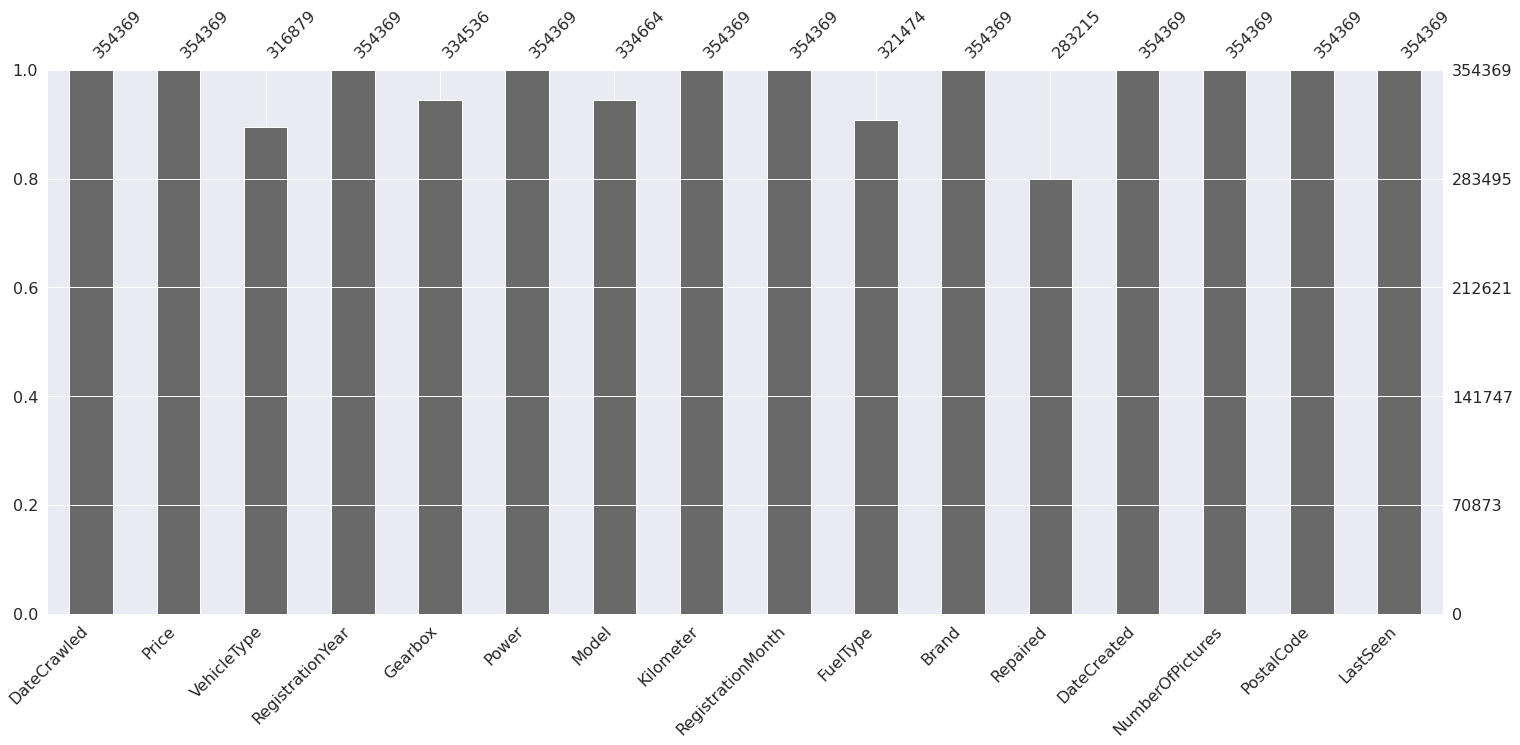

In [ ]:
msno.bar(autos)

<font size="3">
    
**Вывод раздела:**

Полученный датафрейм содержит следующие данные:

**Признаки**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

⠀**Целевой признак**
* `Price` — цена (в евро)

Предварительно можно утверждать, что данных достаточно для проведения исследования.

В датасетах имеются пропущенные значения, столбцы датафреймов следует переименовать.
    
Стоит подробнее изучить тип имеющихся данных, а также в данных могут присутствовать дубликаты.

---

## Предобработка данных

<font size="3"> Проведём предобработку данных.

### Отбор данных

<font size="3"> Определим столбцы, которые попадут в обучающую выборку модели: данные в этих столбцах влияют на формирование цены автомобиля.

<font size="3">

- `VehicleType` - тип кузова автомобиля влияет на его ценообразование, так как определяет функционал авто: использование в городе или на бездорожье, "статусный" или "семейный" итд;
- `RegistrationYear`- возраст автомобиля также влияет на его цену, так как определяет, сколько машина уже находится в эксплуатации. Чем раньше был выпущен автомобиль, тем ниже будет запрашиваемая цена;
- `Gearbox` - ввиду более удобной эксплуатации в условиях бездорожья, в сельской местности и пригороде автомобиль с механикой может стоить дороже. В остальных случаях АКПП оценивается выше;
- `Power` - количество лошадиных сил учитывается при расчёте размера акциза, что также влияет на ценообразование авто;
- `Model` - определенные модели автомобилей имеют более высокий спрос, что влияет на стоимость;
- `Kilometer` - износа агрегатов имеет обратно пропорциональную зависимость с ценой автомобиля;
- `FuelType` - определяет конструкцию двигателя и расход топлива, что влияет на ценообразование авто;
- `Brand` - история бренда и репутация производителя играют большую роль в ценовой политике;
- `Repaired` - влияет на состояние кузова автомобиля, что, в свою очередь, отражается на цене авто.
    
    
Остальные признаки не попадут в обучающую выборку, удалим их из датафрейма, это:
- `DateCrawled`
- `RegistrationMonth`
- `DateCreated`
- `NumberOfPictures`
- `PostalCode`
- `LastSeen`

In [ ]:
# сохраним копию датафрейма до изменений
autos_unprocessed = autos.copy()

# удалим неинформативные признаки
autos.drop(
    [
        "DateCrawled",
        "RegistrationMonth",
        "DateCreated",
        "NumberOfPictures",
        "PostalCode",
        "LastSeen",
    ],
    axis=1,
    inplace=True,
)

# проверим результат
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<font size="3">

**Вывод**

Отобраны только информативные признаки для проведения исследования.

### Проверка явных дубликатов

<font size="3"> Проверим наличие явных дубликатов в датафрейме.

In [ ]:
autos.duplicated().sum()

45040

<font size="3"> Удалим найденные строки из датафрейма, чтобы модель не переобучилась на одинаковых строках:

In [ ]:
autos.drop_duplicates(keep="first", ignore_index=True, inplace=True)

# Проверим результат
autos.duplicated().sum()

0

<font size="3">

**Вывод**

Явные дубликаты удалены.

### Именование столбцов


<font size="3"> Приведём названия столбцов датафрейма к стандарту: сделаем нижний регистр и разделим слова по символу "_".

In [ ]:
autos.columns = [re.sub(r'(?<!^)([A-Z])', r'_\1', column).lower() for column in autos.columns]

#проверим результат
autos.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

<font size="3">

**Вывод**

Столбцы датафрейма именованы корректно.

### Тип данных


<font size="3"> Убедимся, что в датафрейме корретный тип данных.

In [ ]:
autos.dtypes

price                 int64
vehicle_type         object
registration_year     int64
gearbox              object
power                 int64
model                object
kilometer             int64
fuel_type            object
brand                object
repaired             object
dtype: object

<font size="3">

**Вывод**

Все столбцы датафрейма содержат корректный тип данных:
    
- количественные столбцы имеют тип `int64`;
- категориальные - тип `object`.

### Проверка пропусков

<font size="3"> Гистограммы `msno` показали наличие пропущенных значений в датафрейме, изучим их подробнее.

In [ ]:
# считаем количеством пропущенных значений
missing_counts = autos.isna().sum()

# считаем процент пропущенных значений в столбце
missing_percentages = pd.DataFrame()
for col in autos.columns:
    pct_missing = np.mean(autos[col].isnull())
    missing_percentages[col] = [round(pct_missing*100)]

# объединяем таблицы
missing_info = pd.concat([missing_counts, missing_percentages.T], axis=1)
missing_info.columns = ['Missing Count', 'Missing Percentage']

display(missing_info)

,Missing Count,Missing Percentage
price,0,0
vehicle_type,34559,11
registration_year,0,0
gearbox,17207,6
power,0,0
model,18361,6
kilometer,0,0
fuel_type,30764,10
brand,0,0
repaired,64558,21


<font size="3">

Столбцы, в которых пропущенные значения составляют 50% и более, отсутствуют - на данном этапе нет необходимости удалять признаки из-за пропущенных значений.
    
Заполним пропущенные значения в столбцах категорией-заглушкой, чтобы для построения прогноза модель использовала только достоверные данные.

In [ ]:
#заполним пропуски по выбранному алгоритму
autos.fillna(
    {
        "repaired": "unknown",
        "vehicle_type": "unknown",
        "gearbox": "unknown",
        "model": "unknown",
        "fuel_type": "unknown",
    },
    inplace=True,
)

#проверим результат
autos.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

<font size="3">
    
**Вывод:**
    
Пропущенные значения обработаны.

### Проверка неявных дубликатов

<font size="3"> Проверим значения категориальных столбцов датафрейма на уникальность.

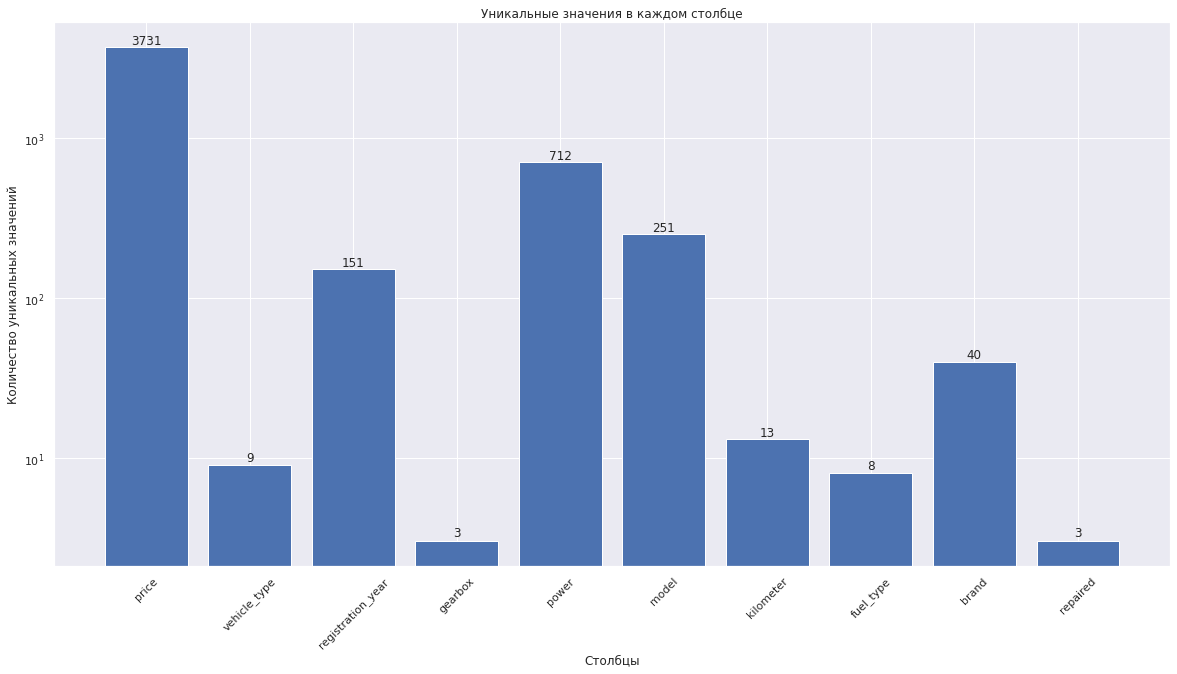

In [ ]:
# создаем список для хранения количества уникальных значений в каждом столбце
unique_values_count = []

# перебираем все столбцы датафрейма
for column in autos.columns:
    unique_values_count.append(len(autos[column].unique()))

# строим столбчатую гистограмму
plt.figure(figsize=(20, 10))
bars = plt.bar(autos.columns, unique_values_count,  log=True)
plt.xlabel('Столбцы')
plt.ylabel('Количество уникальных значений')
plt.title('Уникальные значения в каждом столбце')
plt.xticks(rotation=45)

# добавляем количество уникальных значений над каждым баром
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

plt.show()

<font size="3"> В датафрейме отсутствуют категориальные столбцы с высокой вариативностью, изучим каждый столбец подробнее.

<font size="3">
    
- признак **'vehicle_type'**

In [ ]:
autos['vehicle_type'].value_counts()

sedan          78206
small          67548
wagon          56367
unknown        34559
bus            25830
convertible    18195
coupe          14690
suv            10776
other           3158
Name: vehicle_type, dtype: int64

<font size="3"> Неявные дубликаты отсутствуют.

<font size="3">
    
- признак **'gearbox'**

In [ ]:
autos['gearbox'].value_counts()

manual     232774
auto        59348
unknown     17207
Name: gearbox, dtype: int64

<font size="3"> Неявные дубликаты отсутствуют.

<font size="3">
    
- признак **'model'**

In [ ]:
autos['model'].value_counts()

golf                  23639
other                 22934
unknown               18361
3er                   16700
polo                  10494
                      ...  
kalina                    7
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        1
Name: model, Length: 251, dtype: int64

<font size="3"> Признак содержит 251 уникальное значение, что нормально для данных о модели автомобиля.
    
Рассмотрим подробнее частично совпадающие категории на наличие неявных дубликатов через разное написание одной и той же модели авто:

In [ ]:
models = autos['model'].unique()

threshold = 0.3  # порог сходства
similar_models = {}
already_printed = set()

for c in models:
    similar_models[c] = []
    for s in models:
        if c != s and distance(c, s) < math.ceil(len(c) * threshold):
            similar_models[c].append(s)

    if similar_models[c]:
        for model in similar_models[c]:
            if model not in already_printed:
                print(c, similar_models[c])
                already_printed.add(c)
                already_printed.update(similar_models[c])

2_reihe ['3_reihe', 'xc_reihe', 'z_reihe', 'i_reihe', '6_reihe', '5_reihe', 'rx_reihe', '1_reihe', '4_reihe', 'x_reihe', 'mx_reihe', 'cr_reihe', 'c_reihe', 'm_reihe', 'cx_reihe']
c_max ['s_max', 'b_max']
a_klasse ['e_klasse', 'b_klasse', 'c_klasse', 's_klasse', 'v_klasse', 'm_klasse', 'g_klasse']
roomster ['roadster']
x_type ['s_type']
range_rover ['rangerover']
serie_2 ['serie_3', 'serie_1']
9000 ['900']
range_rover_sport ['range_rover_evoque']


<font size="3"> Выявлены следующие неявные дубликаты:
    
- `range_rover` и `rangerover`, объединим их в одну категорию.
    
Остальные найденные модели уникальны.

In [ ]:
# заменим все вхождения "range_rover" на "rangerover"
autos["model"] = autos["model"].replace(["range_rover"], "rangerover", regex=True)

# проверим результат
autos['model'].nunique()

250

<font size="3"> Количество уникальных категорий уменьшилось, неявные дубликаты обработаны.

<font size="3">
    
- признак **'fuel_type'**

In [ ]:
autos['fuel_type'].value_counts()

petrol      187848
gasoline     84794
unknown      30764
lpg           4888
cng            524
hybrid         222
other          200
electric        89
Name: fuel_type, dtype: int64

<font size="3"> Объединим `petrol` и `gasoline` в одну категорию `petrol`:

In [ ]:
# заменим все вхождения "range_rover" на "rangerover"
autos["fuel_type"] = autos["fuel_type"].replace(["gasoline"], "petrol", regex=True)

# проверим результат
autos['fuel_type'].nunique()

7

<font size="3"> Количество уникальных категорий уменьшилось, неявные дубликаты обработаны.

<font size="3">
    
- признак **'brand'**

In [ ]:
autos['brand'].value_counts()

volkswagen        63907
opel              33957
bmw               31716
mercedes_benz     28696
audi              25470
ford              22400
renault           15798
peugeot            9808
fiat               8675
seat               6188
mazda              5113
skoda              4967
smart              4823
citroen            4798
nissan             4489
toyota             4248
hyundai            3295
sonstige_autos     2931
volvo              2907
mini               2866
mitsubishi         2812
honda              2637
kia                2247
suzuki             2158
alfa_romeo         2142
chevrolet          1648
chrysler           1352
dacia               830
daihatsu            752
subaru              726
porsche             699
jeep                639
trabant             555
daewoo              508
land_rover          507
saab                484
jaguar              479
rover               449
lancia              443
lada                210
Name: brand, dtype: int64

<font size="3"> Неявные дубликаты отсутствуют.

<font size="3">
    
- признак **'repaired'**

In [ ]:
autos['repaired'].value_counts()

no         211328
unknown     64558
yes         33443
Name: repaired, dtype: int64

<font size="3"> Неявные дубликаты отсутствуют.

---

<font size="3">

**Вывод раздела**

Для корректного проведения исследования выполнена предобработка данных:

- Отобраны информативные признаки;
- Столбцы именованы корректно;
- Проверены типы данных;
- Изучены и обработаны пропуски в датафреймах;
- Проверены дубликаты в датафреймах, в том числе и неявные.

---
## Исследовательский анализ данных

<font size="3"> Проведём исследовательский анализ количественных признаков датафрейма.

### Количественные признаки

<font size="3"> Напишем функцию `visuals`, которая построит гистограмму распределения, коробчатую диаграмму и выведет метод `describe()`:

In [ ]:
def visuals(cat):
    display(autos[cat].describe())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

    autos[cat].plot(kind='hist', bins=20, ax=axes[0])
    axes[0].set_title('Гистограмма распределения', fontsize=14)
    axes[0].set_ylabel('Частота встречаемости')
    axes[0].set_xlabel('Наблюдаемые значения')

    autos[cat].plot(kind='box', ax=axes[1], rot=0)
    axes[1].set_title('Разброс значений признаков', fontsize=14)
    axes[1].set_xlabel('Категория')
    axes[1].set_ylabel('Наблюдаемые значения')
    plt.show()

<font size="3">
    
- Признак **'price'**

count   309,329.000
mean      4,486.937
std       4,564.853
min           0.000
25%       1,100.000
50%       2,800.000
75%       6,500.000
max      20,000.000
Name: price, dtype: float64

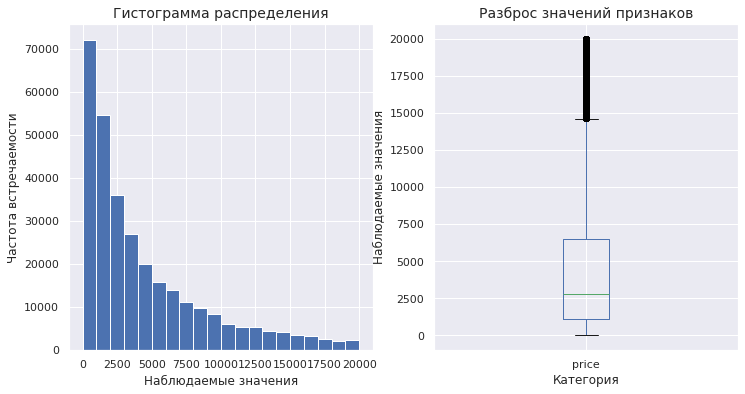

In [ ]:
visuals('price')

<font size="3"> На графике отмечается пик при нуле, изучим подробнее значения признака:

In [ ]:
autos['price'].value_counts()

0        8904
500      4650
1500     4533
1000     3875
1200     3799
         ... 
1654        1
5748        1
7285        1
11379       1
8188        1
Name: price, Length: 3731, dtype: int64

<font size="3"> Выборка содержит 10 772 объекта без цены - удалим данные строки, установив минимальную границу стоимости авто в 50 Евро (~5000 рублей).
    
Также коробчатая гистограмма относит автомобили, стоимостью более 15 000 евро, к выборосам. Максимальное значение цены в выборке - 20 000 евро (~ 2 млн. рублей) в текущих реалиях вполне приемлемая цена даже за б/у автомобиль.

<br> Таким образом, получим реалистичный диапазон цен в границах 50 - 20 000 Евро.

In [ ]:
autos = autos[autos['price'] > 50]

count   298,590.000
mean      4,648.225
std       4,564.868
min          55.000
25%       1,200.000
50%       2,950.000
75%       6,700.000
max      20,000.000
Name: price, dtype: float64

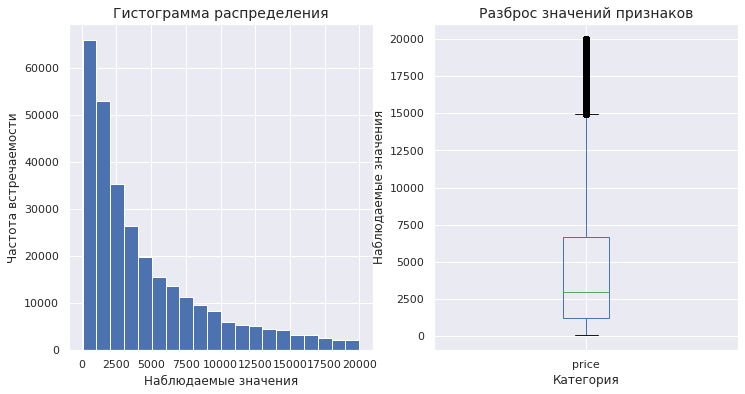

In [ ]:
# проверим распределение после изменений
visuals('price')

<font size="3">
    
**Вывод**

Признак `price` - целевой, цена автомобиля.
    
Распределение признака асимметрично вправо с длинным хвостом, большинство значений располагается в промежутке от 1 200 до 6 700 евро.

Выбросы и аномалии в данных изучены и обработаны.

<font size="3">
    
- Признак **'registration_year'**

count   298,590.000
mean      2,004.182
std          78.914
min       1,000.000
25%       1,999.000
50%       2,003.000
75%       2,008.000
max       9,999.000
Name: registration_year, dtype: float64

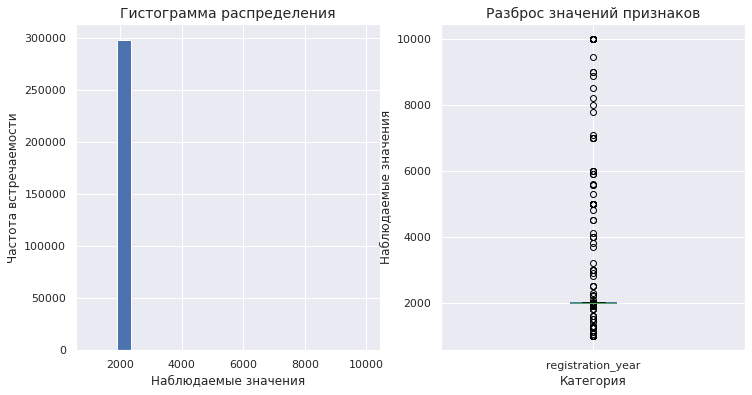

In [ ]:
visuals('registration_year')

<font size="3"> На графике отмечаются выбросы в виде некорректного года регистрации автомобилей, найдём макисмальную дату скачивания анкеты из базы:

In [ ]:
date_max = pd.to_datetime(autos_unprocessed['DateCrawled'])
date_max.max()

Timestamp('2016-04-07 14:36:58')

<font size="3"> Отсечём правый хвост по найденной дате - 2016 год.
    
<br> Обработаем выбросы левого хвоста: оставим только автомобили, зарегистрированные не ранее 1980 года, такие автомобили возможно ещё появляются в продаже.

In [ ]:
autos = autos[(autos['registration_year'] > 1979) & (autos['registration_year'] < 2016)]

count   274,413.000
mean      2,002.581
std           5.776
min       1,980.000
25%       1,999.000
50%       2,003.000
75%       2,007.000
max       2,015.000
Name: registration_year, dtype: float64

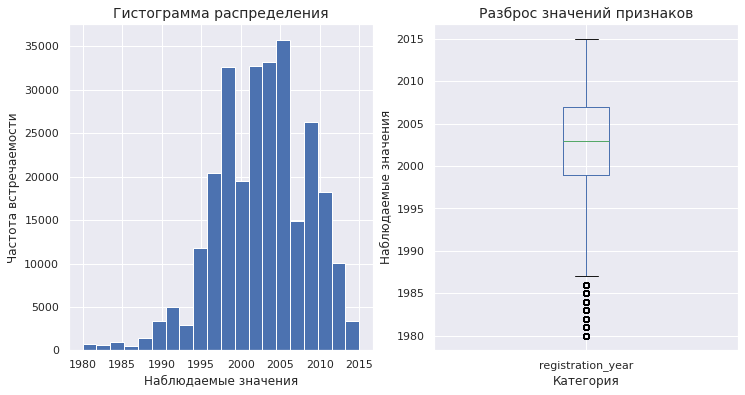

In [ ]:
# проверим распределение после изменений
visuals('registration_year')

<font size="3">
    
**Вывод**

Признак `registration_year` - год регистрации автомобиля.
    
Признак имеет нормальное распределение, большинство значений располагается в промежутке от 1999 до 2007 года регистрации.

Выбросы и аномалии в данных изучены и обработаны.

<font size="3">
    
- Признак **'power'**

count   274,413.000
mean        114.376
std         191.421
min           0.000
25%          75.000
50%         106.000
75%         144.000
max      20,000.000
Name: power, dtype: float64

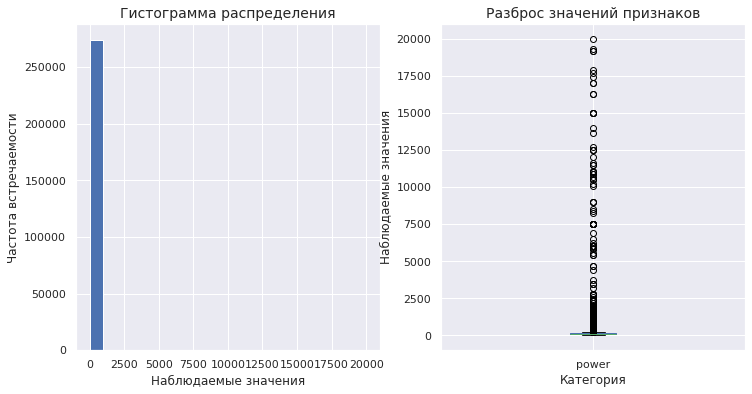

In [ ]:
visuals('power')

<font size="3"> На графике отмечаются некорректные значения мощности автомобиля в лошадиных силах. Изучим значения признака подробнее:

In [ ]:
autos['power'].value_counts()

0       25589
75      17019
150     11599
60      11238
140     10249
        ...  
1689        1
1433        1
409         1
1432        1
3750        1
Name: power, Length: 663, dtype: int64

<font size="3"> У 25 589 объектов отсутствуют данные о мощности двигателя, удалим данные строки.
    
<br> У популярных автомобилей 80-х мощность составляла 50 - 130 лошадиных сил. Для левого хвоста возьмём предел в 50 лошадиных сил, для правого - в 800, чтобы сохранить в выборке современные автомобили с высокой мощностью.

In [ ]:
autos = autos[(autos['power'] > 49) & (autos['power'] < 801)]

count   244,439.000
mean        123.616
std          53.820
min          50.000
25%          83.000
50%         116.000
75%         150.000
max         800.000
Name: power, dtype: float64

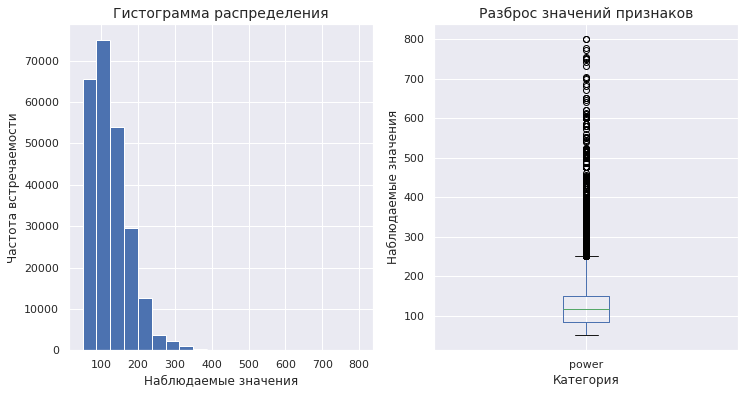

In [ ]:
# проверим распределение после изменений
visuals('power')

<font size="3">
    
**Вывод**

Признак `power` - мощность автомобиля в лошадиных силах.
    
Признак несколько ассиметричен вправо, большинство значений располагается в промежутке от 83 до 150 лошадиных сил.

Выбросы и аномалии в данных изучены и обработаны.

---

### Категориальные признаки

<font size="3">
    
Изучим категориальные признаки датафрейма `autos`.

Напишем функцию `cat_visuals`, которая визуализирует признак с помощью столбчатой гистограммы.

In [ ]:
#функция для визуализации 10 самых часто встречающихся значений без учёта категории-заглушки
def cat_visuals_top(cat):
    filtered_data = autos[autos[cat] != 'unknown']

    ax = sns.countplot(x=filtered_data[cat],
                   order=filtered_data[cat].value_counts(ascending=False).head(10).index);

    abs_values = filtered_data[cat].value_counts(ascending=False).head(10).values

    ax.bar_label(container=ax.containers[0], labels=abs_values)
    ax.set_title('Распределение категорий признака ' + cat)
    ax.set(xlabel='Категории', ylabel='Частота встречаемости')
    ax.figure.set_size_inches(20,8);

<font size="3">
    
- Признак **'vehicle_type'**

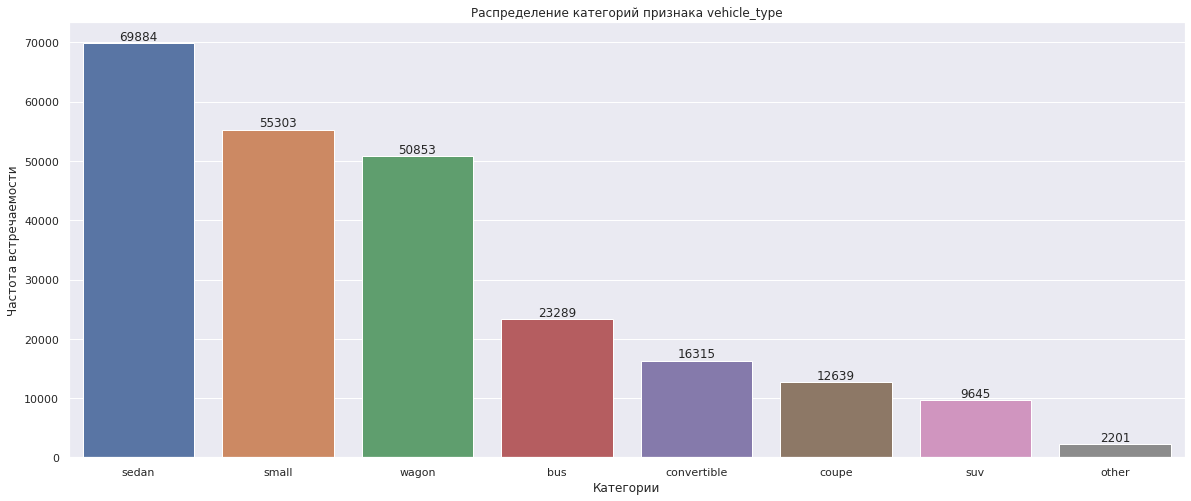

In [ ]:
cat_visuals_top('vehicle_type')

<font size="3">
    
**Вывод**

Признак `vehicle_type` представлен категориями:
- sedan         
- small       
- wagon       
- bus         
- convertible   
- coupe     
- suv        
- other
    
В выборке преобладает тип кузова «sedan».

<font size="3">
    
- Признак **'gearbox'**

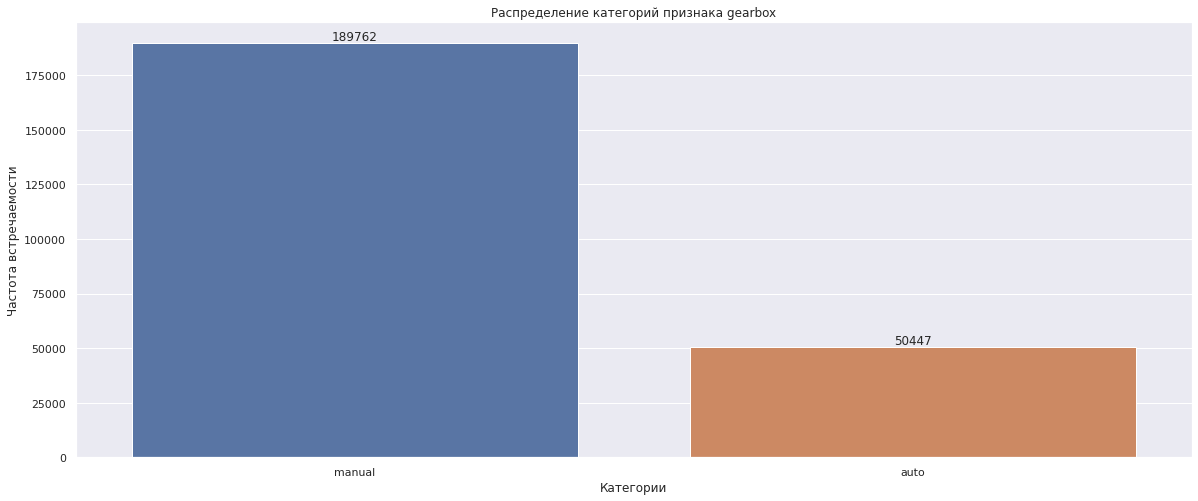

In [ ]:
cat_visuals_top('gearbox')

<font size="3">
    
**Вывод**

Признак `gearbox` представлен категориями:
- manual
- auto
    
В выборке преобладает тип коробки передач «manual».

<font size="3">
    
- Признак **'model'**

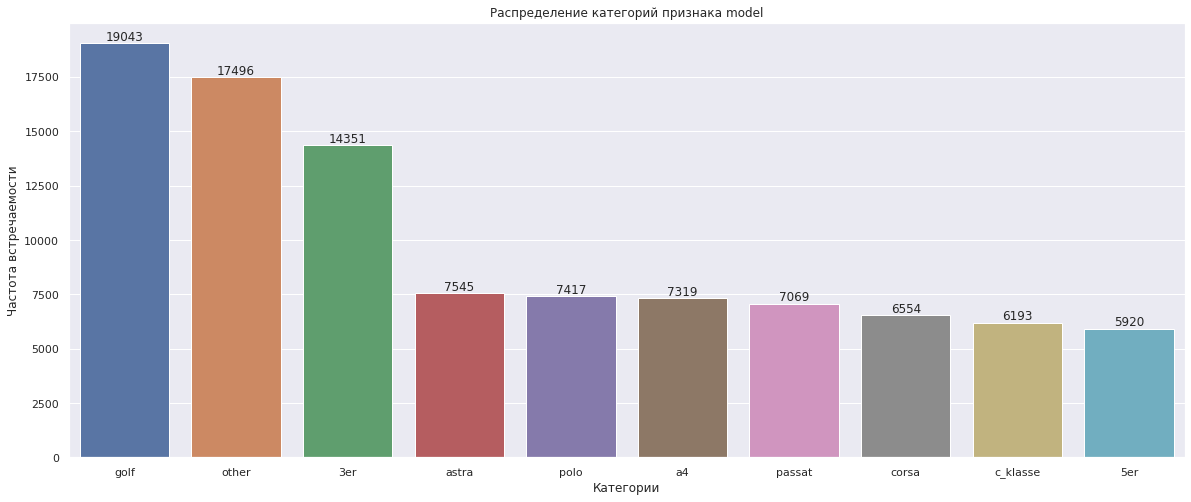

In [ ]:
cat_visuals_top('model')

<font size="3">
    
**Вывод**

Признак `model` представлен моделями автомобилей, в топ-10 самых частых категорий вошли:
    
- golf
- other
- 3er
- astra
- polo
- a4
- passat
- corsa
- c_klasse
- 5er
    
В выборке преобладают модели «golf», «3er» и сборная категория «other».

<font size="3">
    
- Признак **'fuel_type'**

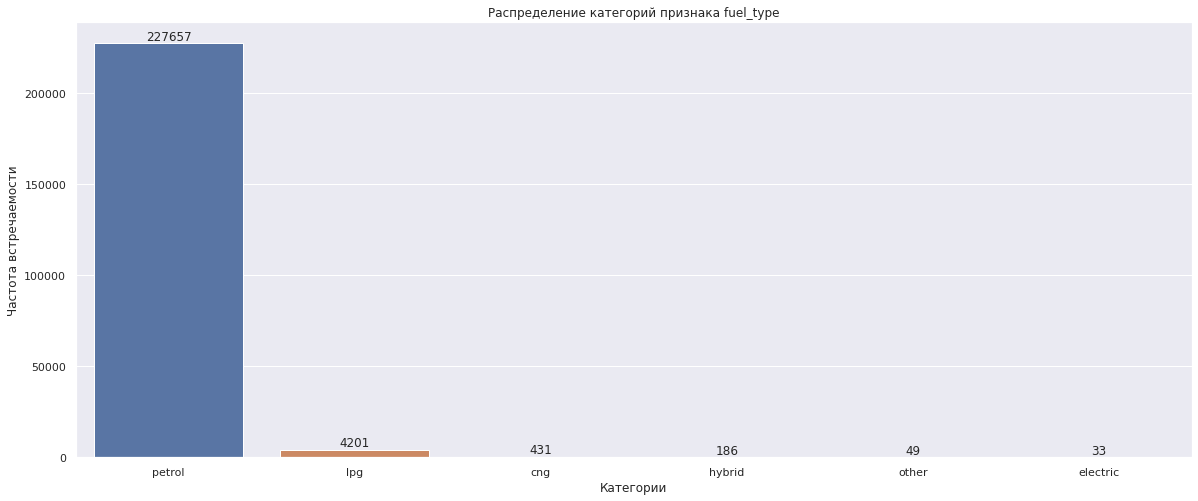

In [ ]:
cat_visuals_top('fuel_type')

<font size="3">
    
**Вывод**

Признак `fuel_type` представлен категориями:
    
- petrol
- lpg
- cng
- hybrid
- other
- electric
    
В выборке преобладает тип топлива «petrol».

<font size="3">
    
- Признак **'brand'**

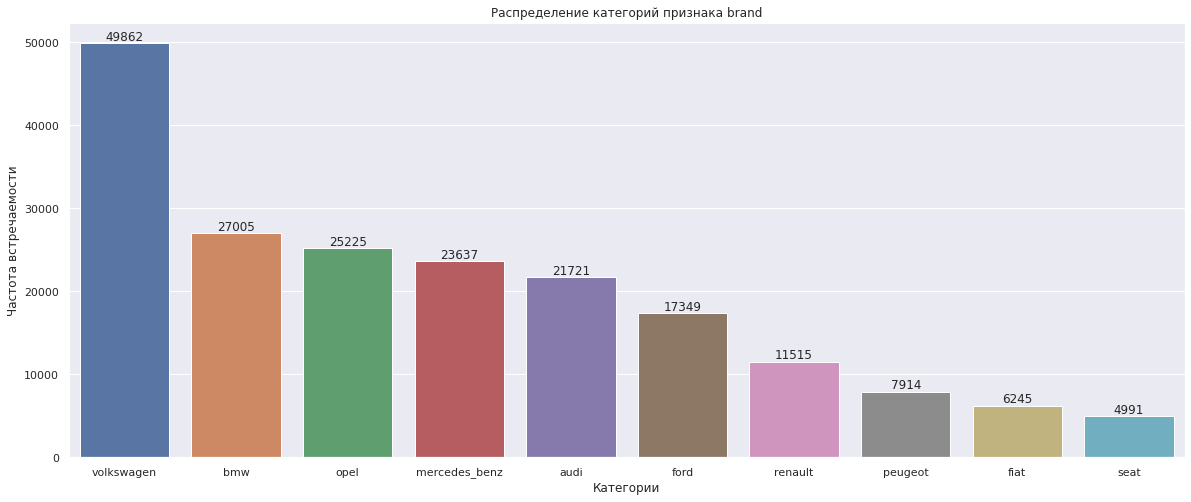

In [ ]:
cat_visuals_top('brand')

<font size="3">
    
**Вывод**

Признак `brand` представлен марками автомобилей, в топ-10 самых частых категорий вошли:
    
- volkswagen
- bmw
- opel
- mercedes_benz  
- audi          
- ford         
- renault        
- peugeot       
- fiat           
- seat                
    
В выборке преобладает бренд «volkswagen».

<font size="3">
    
- Признак **'repaired'**

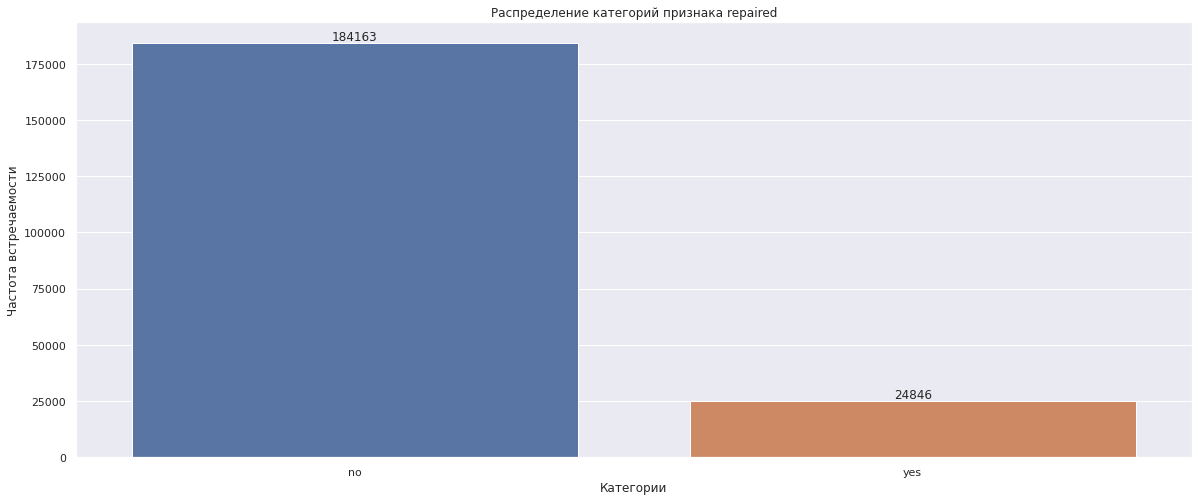

In [ ]:
cat_visuals_top('repaired')

<font size="3">
    
**Вывод**

Признак `repaired` представлен категориями:
    
- no
- yes
    
В выборке преобладает категория «no».

---
<font size="3"> Исследовательский анализ данных завершён, посмотрим, как изменился наш датафрейм после всех преобразований:

In [ ]:
# вычисляем процент данных, которые остались после обработки
percent_remaining = (len(autos) / len(autos_unprocessed)) * 100

# удаляем копию датафрейма с исходными данными
del autos_unprocessed

print(f"Сохранилось данных после предобработки и анализа: {percent_remaining:.2f}%")

Сохранилось данных после предобработки и анализа: 68.98%


---
<font size="3">

**Вывод раздела**

В датафрейме `autos` 6 категориальных и 4 количественных признака, включая целевой.
    
Выбросы и аномалии в данных обработаны.
            
<br> В ходе очистки данных от выбросов и аномалий исходный датафрейм уменьшился на 31.02%.

---
## Корреляционный анализ

<font size="3"> Проведём корреляционный анализ признаков датафрейма.

Признак `price` - целевой, изучим взаимосвязь входных признаков с целевым, а также выявим мультиколлинеарность признакового описания при его наличии.

### Матрица корреляции

<font size="3"> Корреляцию признаков рассмотрим с помощью матрицы корреляций `phik_matrix()`.

In [ ]:
# функция построения матрицы корреляций phik
def phik_matrix(df):
    # список интервальных признаков
    interval_cols = df.select_dtypes(include='number').columns.tolist()

    # вычисление коэффициентов корреляции phi для датафрейма
    phik_overview = df.phik_matrix(interval_cols=interval_cols)

    # визуализация тепловой карты коэффициентов корреляции
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        title=r"Матрица корреляции $\phi_K$",
        fontsize_factor=1.5,
        figsize=(20, 10)
    )

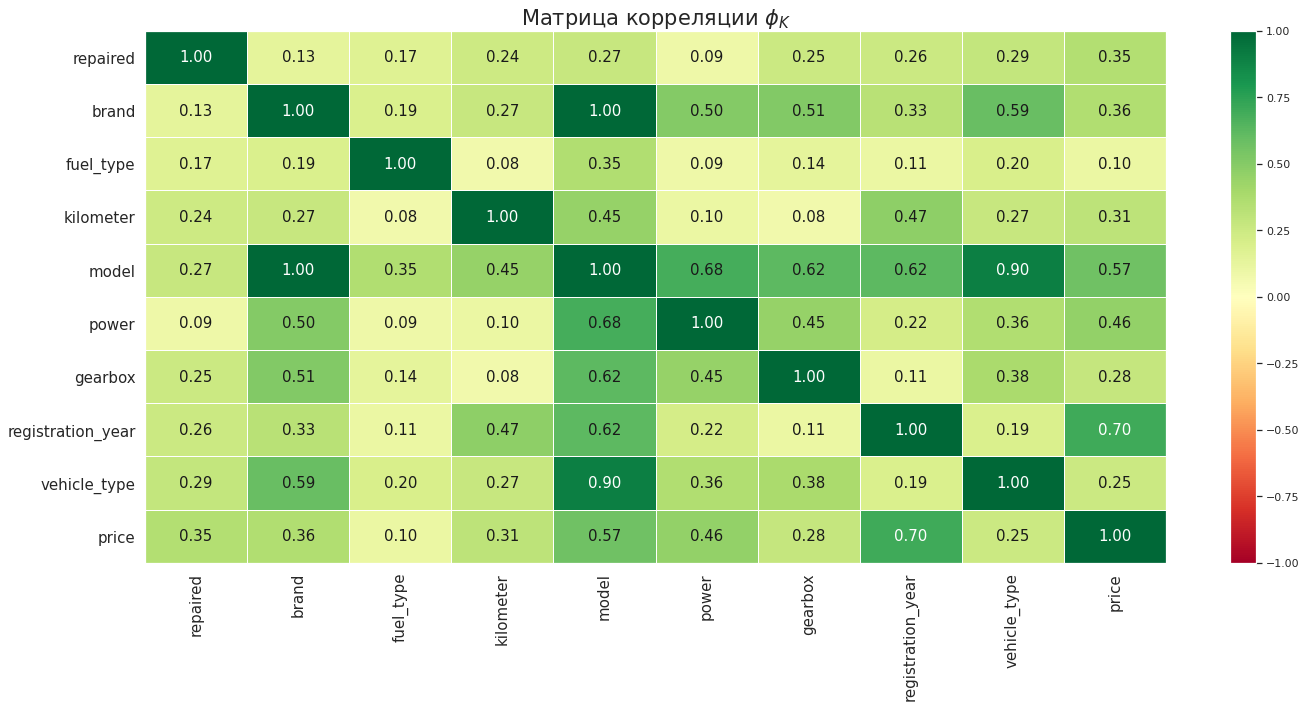

In [ ]:
phik_matrix(autos)

<font size="3">

**Вывод**

Зависимость с целевым признаком `price` выявлена у признаков:
- `registration_year` - высокая зависимость
- `model` - заметная зависимость
- `power` - заметная зависимость

У остальных входных признаков умеренная либо слабая зависимость с целевым.
    
---
    
Также матрица корреляций обнаруживает мультиколлинеарность входных признаков `vehicle_type`, `model` и `brand`.

Удалим признак `model` из выборки, чтобы устранить мультиколлинеарность признакового описания.

In [ ]:
# удалим признак model
autos = autos.drop('model', axis=1)

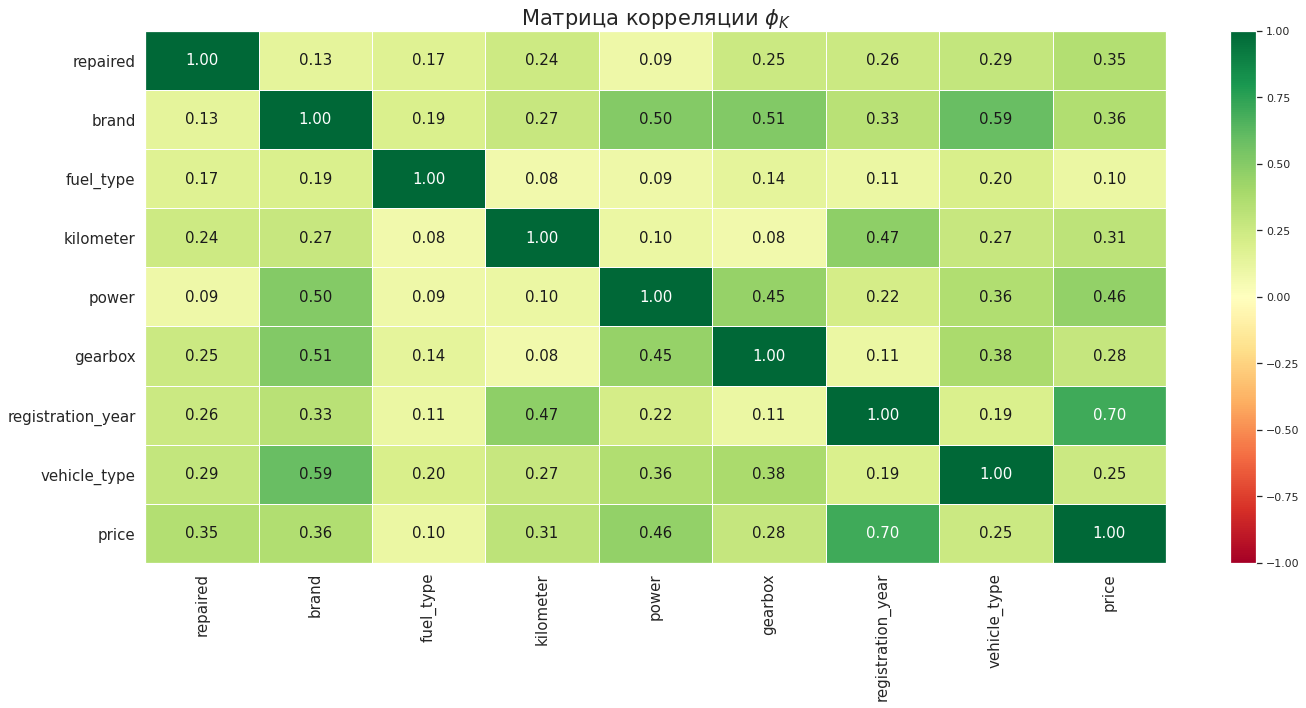

In [ ]:
# построим матрицу повторно
phik_matrix(autos)

<font size="3"> Мультиколлинеарность входных признаков устранена.

---

### Целевой признак

<font size="3"> Целевым в исследовании является количественный признак `price`.
    
    
Рассмотрим сопряжённость целевого признака со всеми признаками датафрейма.

<font size="3"> **Количественные признаки**
    

Напишем функцию `target_num` для построения графика `scatterplot`, которая визуализирует зависимость целевого признака от входных количественных признаков.

    
<br>Предварительно в теле функции сгруппируем датафрейм по входному количественному признаку и для построения графика возьмём среднее значение каждой группы.

In [ ]:
def target_num(quant, pos):
    fig, axes = plt.subplots(figsize=(12,6))

    sns.scatterplot(data=autos.groupby(quant)[['price']].mean(), \
                    x=quant, y="price", ax=axes, hue=('price'))\
    .set(title='Зависимость признаков "price" и "' + quant + '"')

    plt.legend(loc=pos)

<font size="3">
    
- Признак **'registration_year'**

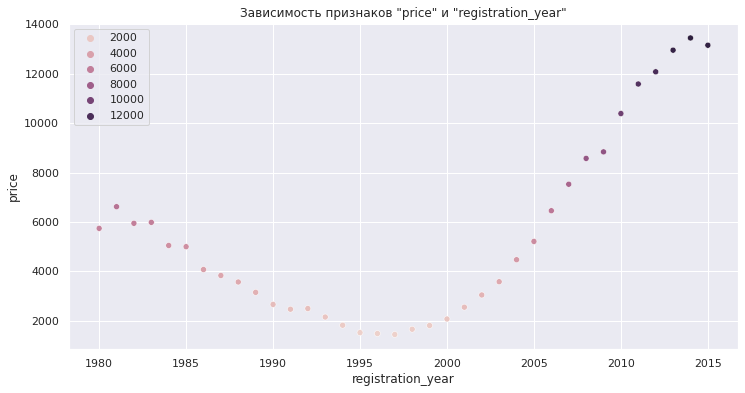

In [ ]:
target_num('registration_year', 'upper left')

<font size="3">
    
**Вывод**

Между целевым признаком `price` и входным признаком `registration_year` отмечается зависимость: высоким значениям года регистрации авто соответствует более высокая цена авто.

<font size="3">
    
- Признак **'power'**

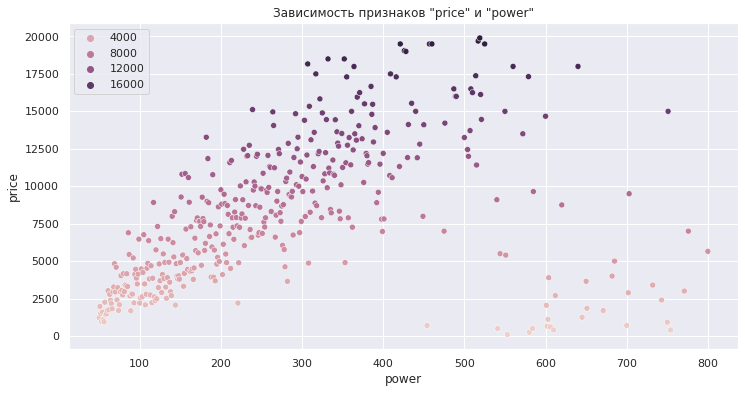

In [ ]:
target_num('power', 'upper left')

<font size="3">
    
**Вывод**

Между целевым признаком `price` и входным признаком `power` отмечается зависимость: высоким значениям мощности двигателя соответствует более высокая цена авто.

<font size="3">
    
- Признак **'kilometer'**

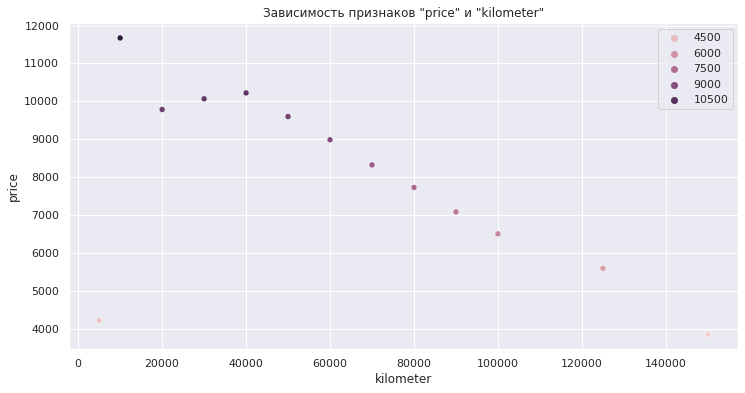

In [ ]:
target_num('kilometer', 'upper right')

<font size="3">
    
**Вывод**

Между целевым признаком `price` и входным признаком `kilometer` отмечается зависимость: низким значениям пробега соответствует более высокая цена авто.

---

<font size="3"> **Категориальные признаки**
    
    
Напишем функцию `target_cat` для отображения распределения целевого признака `price` в разрезе категориальных входных признаков.

In [ ]:
def target_cat(col):
    top_categories = autos[col][autos[col] != 'unknown'].value_counts().head(10).index

    fig, axes = plt.subplots(figsize=(20,6))

    sns.violinplot(data=autos[autos[col].isin(top_categories)], x=col, y='price', ax=axes)

    plt.title("Распределение признака 'price' в разрезе признака " + col)
    plt.xlabel("признак " + col)
    plt.ylabel("Признак 'price'");

<font size="3">
    
- Признак **'vehicle_type'**

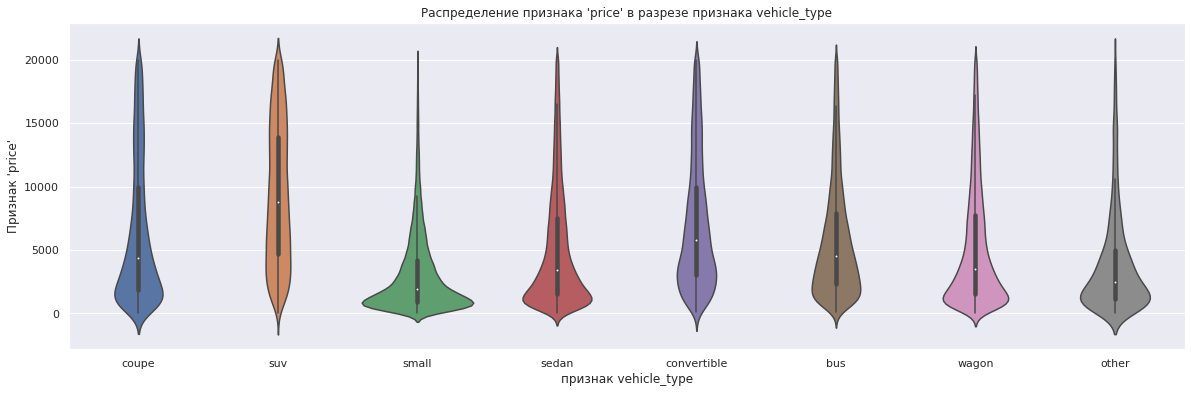

In [ ]:
target_cat('vehicle_type')

<font size="3">
    
**Вывод**

Визуализация показывает, что более высокую медианную стоимость имеют авто в кузове «suv» и «convertible», самая низкая - у «small».
    
Медианная стоимость автомобилей иного типа кузова однородна.

<font size="3">
    
- Признак **'gearbox'**

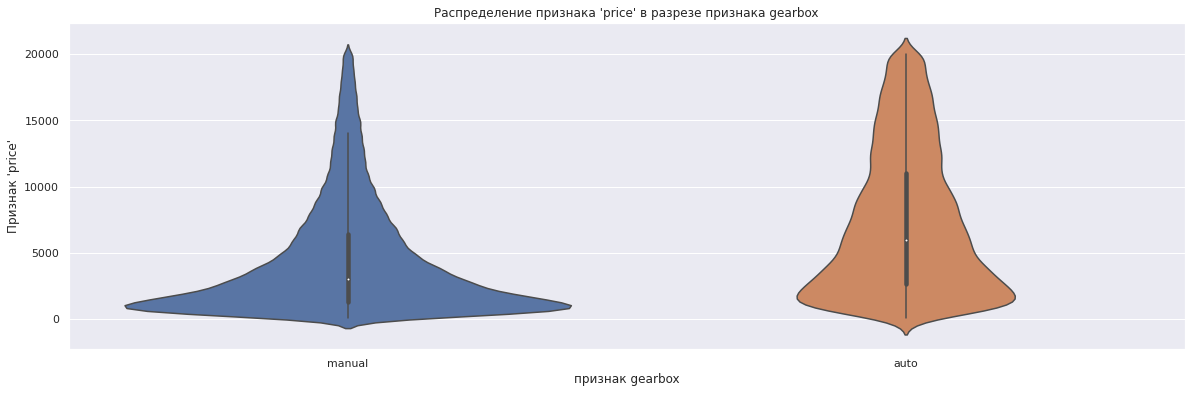

In [ ]:
target_cat('gearbox')

<font size="3">
    
**Вывод**

Визуализация показывает, что автомобили с АКПП имеют более высокую медианную стоимость по сравнению с авто с МКПП.

<font size="3">
    
- Признак **'fuel_type'**

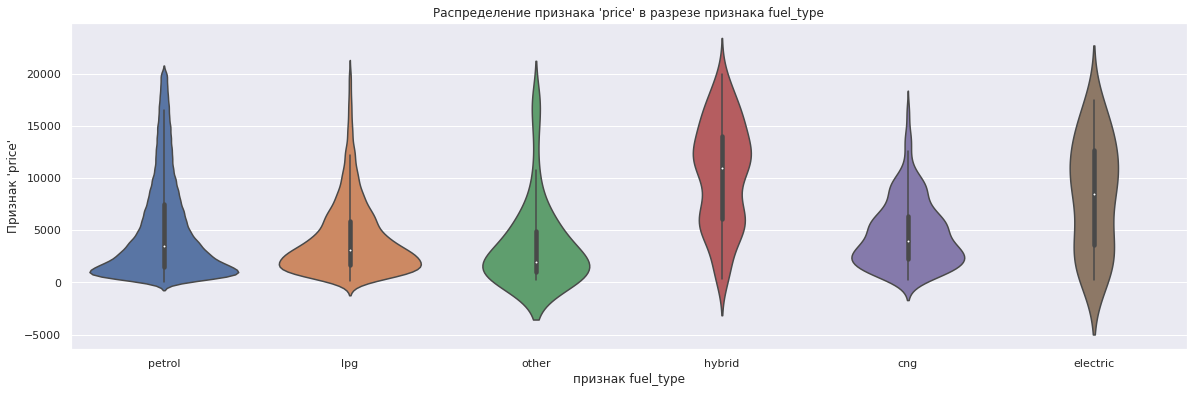

In [ ]:
target_cat('fuel_type')

<font size="3">
    
**Вывод**

Визуализация показывает, что наиболее высокая медианная стоимость у авто с типом топлива «electric» и  «hybrid».
    
Медианная стоимость автомобилей, имеющих иной тип топлива, однородна.

<font size="3">
    
- Признак **'brand'**

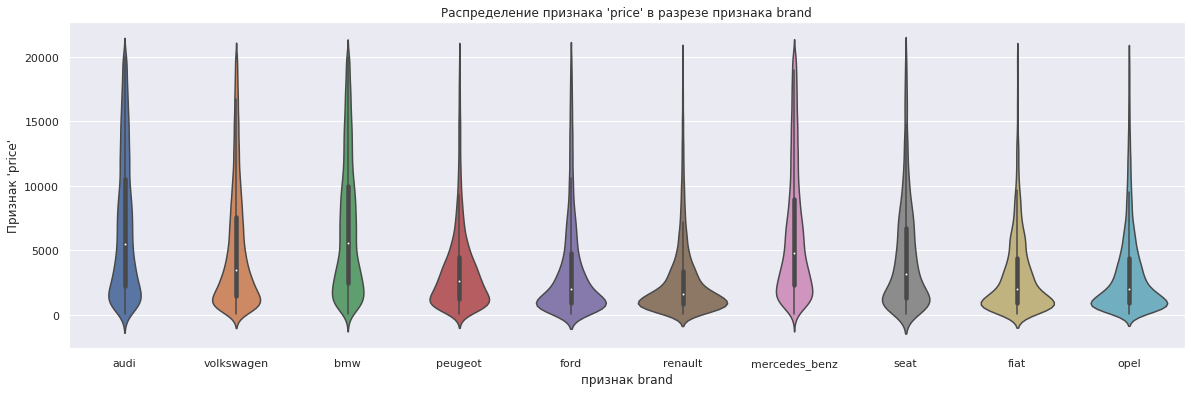

In [ ]:
target_cat('brand')

<font size="3">
    
**Вывод**

Визуализация показывает, что наиболее высокая медианная стоимость марки «bmw», «audi» и «mercedes_benz».
    
Медианная стоимость автомобилей иных марок однородна.

<font size="3">
    
- Признак **'repaired'**

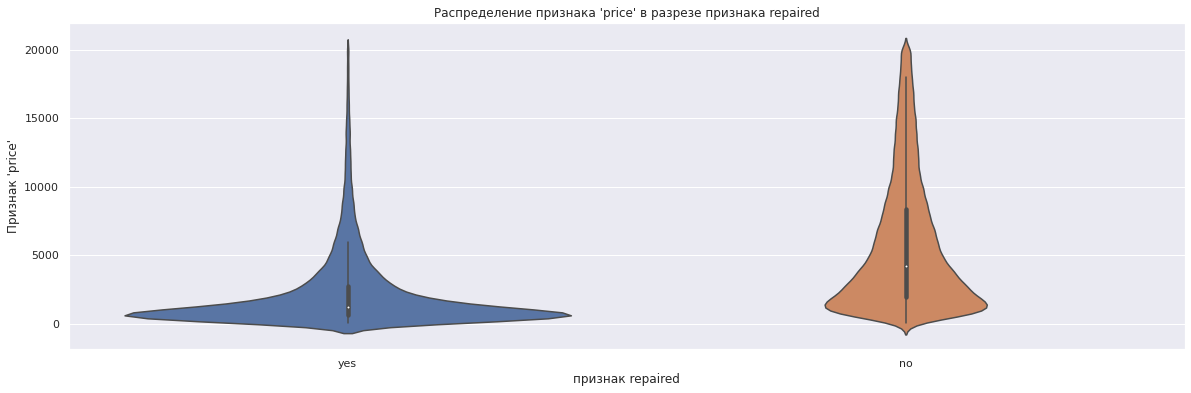

In [ ]:
target_cat('repaired')

<font size="3">
    
**Вывод**

Визуализация показывает, что более высокая медианная стоимость у автомобилей без ремонта.

---

<font size="3">

**Вывод раздела**

Зависимость с целевым признаком `price` выявлена у признаков:
- `registration_year` - высокая
- `power` - заметная

У остальных входных признаков умеренная либо слабая зависимость с целевым.
    
---
    
Мультиколлинеарность признакового описания устранена.

---

## Обучение моделей

<font size="3">
    
В данном шаге напишем и обучим несколько моделей для предсказания цены автомобиля.
    
Для решения задачи выберем следующие регрессоры:
- `Ridge()`;
- `RandomForestRegressor()`;
- `LGBMRegressor()`;
- `CatBoostRegressor()`.
       
Качество модели оценим с помощью метрики `RMSE`.
    
Для каждой модели добавим разные гиперпараметры, а также посчитаем время обучения и предсказания модели.

---

### Формирование выборок

<font size="3"> Подготовим данные к обучению и напишем функцию для расчёта времени обучения и получения прогноза.

In [ ]:
# обозначим входные и целевой признаки
X = autos.drop('price', axis=1)
y = autos['price']

# разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE,
)

# создадим списки с названиями признаков
num_columns = X_train.select_dtypes(include='number').columns.tolist()
ohe_columns = X_train.select_dtypes(exclude='number').columns.tolist()
ord_columns = X_train.select_dtypes(exclude='number').columns.tolist()
cat_features = X_train.select_dtypes(exclude='number').columns.tolist()


# функция для записи времени обучения и предсказания моделей
def train_and_predict(model, X_train, y_train, X_test, cat_features=None):
    start_time = time.time()
    if cat_features is not None and isinstance(model, CatBoostRegressor):
        model.fit(X_train, y_train, cat_features=cat_features)
    else:
        model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    return train_time, prediction_time

---

### `Ridge()`

<font size="3"> Напишем пайплайн для обучения модели ридж-регрессии.

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков + OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor_ridge = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_ridge = Pipeline([
    ('preprocessor', data_preprocessor_ridge),
    ('models', Ridge(solver = 'auto', random_state=RANDOM_STATE))
])

# зададим диапазон гиперпараметров
parameters = {
    'models__alpha': distributions.FloatDistribution(0.001, 1.0)
}

# зададим перебор гиперпараметров с помощью Optuna
oscv_ridge = OptunaSearchCV(
    pipe_final_ridge,
    parameters,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_trials=30,
    random_state=RANDOM_STATE,
    verbose=0
)

In [ ]:
oscv_ridge.fit(X_train, y_train)

[I 2024-06-18 14:31:18,382] A new study created in memory with name: no-name-8493e2ac-0a01-465e-88a2-97c1e6dd7577
[I 2024-06-18 14:31:23,005] Trial 0 finished with value: -2574.008685965158 and parameters: {'models__alpha': 0.7641670007568464}. Best is trial 0 with value: -2574.008685965158.
[I 2024-06-18 14:31:27,666] Trial 1 finished with value: -2574.009266824832 and parameters: {'models__alpha': 0.6094296275212849}. Best is trial 0 with value: -2574.008685965158.
[I 2024-06-18 14:31:32,298] Trial 2 finished with value: -2574.008222177797 and parameters: {'models__alpha': 0.918616343009833}. Best is trial 2 with value: -2574.008222177797.
[I 2024-06-18 14:31:37,044] Trial 3 finished with value: -2574.0119992405407 and parameters: {'models__alpha': 0.11786002596503806}. Best is trial 2 with value: -2574.008222177797.
[I 2024-06-18 14:31:42,192] Trial 4 finished with value: -2574.0080352061677 and parameters: {'models__alpha': 0.9941088693064928}. Best is trial 4 with value: -2574.008

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(fill_value='Unknown',
                                                                                                          strategy='constant')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['vehicle_type',
                                                                            'gearbox',
                                                                            'fuel_type',
                                                                            'brand',
                                                                            'repaired']),
                                                                          ('num',
                                                                           StandardScaler(),
                                                                           ['registration_year',
                                                                            'power',
                                                                            'kilometer'])])),
                                         ('models',
                                          Ridge(random_state=12345))]),
               n_jobs=1, n_trials=30,
               param_distributions={'models__alpha': FloatDistribution(high=1.0, log=False, low=0.001, step=None)},
               random_state=12345, scoring='neg_root_mean_squared_error')

In [ ]:
# получим лучшие параметры модели
best_params_ridge = {key.replace('models__', ''): value for key, value in oscv_ridge.best_params_.items()}

# напишем модель Ridge() с лучшими параметрами
tuned_model_ridge = Ridge(
    solver="auto",
    **best_params_ridge,
    random_state=RANDOM_STATE
)

# трансформируем признаки для обучения полученной моделью с помощью data_preprocessor_ridge()
X_train_ridge = pd.DataFrame(data_preprocessor_ridge.fit_transform(X_train))
X_test_ridge = pd.DataFrame(data_preprocessor_ridge.transform(X_test))

# сохраним время обучения и прогнозирования модели
ridge_fit_time, ridge_scores_time = train_and_predict(
    tuned_model_ridge, X_train_ridge, y_train, X_test_ridge
)

# проверим результат
print(f"Время обучения модели: {ridge_fit_time:.4f} секунд, Скорость получения прогноза: {ridge_scores_time:.4f} секунд")

Время обучения модели: 0.1330 секунд, Скорость получения прогноза: 0.0779 секунд


In [ ]:
# выполним кросс-валидацию модели
print('\n\nЛучшая метрика на кросс-валидационной выборке:')
scores_ridge_cv = cross_val_score(tuned_model_ridge, X_train_ridge, y_train, cv=5, scoring='neg_root_mean_squared_error')*-1
print(scores_ridge_cv.mean(), scores_ridge_cv)



Лучшая метрика на кросс-валидационной выборке:
2574.008023592938 [2572.35374425 2592.25269873 2559.79773656 2572.04023955 2573.59569888]


<font size="3">
    
**Вывод**
    
На данном этапе исследования написана модель ridge-регрессии с подбором гиперпараметров, который определил лучшие параметры модели с помощью метрики `RMSE`.
    
Результат работы модели неудовлетворительный:
- Метрика модели на кросс-валидационной выборке: ~2570 Евро

---

### `RandomForestRegressor()`

<font size="3"> Напишем модель случайного леса регрессии.

In [ ]:
# создадим пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков + Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999))
    ]
)

# создадим общий пайплайн для подготовки данных
data_preprocessor_forest = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

# трансформируем признаки для обучения с помощью data_preprocessor_forest()
X_train_forest = pd.DataFrame(data_preprocessor_forest.fit_transform(X_train))
X_test_forest = pd.DataFrame(data_preprocessor_forest.transform(X_test))


# напишем функцию для подбора гиперпараметров с помощью Optuna
def objective_forest(trial):

    # укажем гиперпараметры для перебора
    params_forest = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        "n_jobs": -1,
        "random_state": RANDOM_STATE
    }

    # создадим модель RandomForestRegressor() с предлагаемыми параметрами
    model_forest = RandomForestRegressor(**params_forest)

    # обучим модель
    model_forest.fit(X_train_forest, y_train)

    # получим предсказание на тестовой выборке
    y_pred_forest = model_forest.predict(X_test_forest)

    # получим метрику модели
    rmse_forest = mean_squared_error(y_test, y_pred_forest, squared=False)

    return rmse_forest

In [ ]:
# создадим объект study
study_forest = optuna.create_study(direction="minimize")

# запустим процесс оптимизации
study_forest.optimize(objective_forest, n_trials=30)

[I 2024-06-18 14:33:50,295] A new study created in memory with name: no-name-3248f4a4-04b3-4acf-99a7-a91b7bb5bed4
[I 2024-06-18 14:34:11,541] Trial 0 finished with value: 1675.8584315596845 and parameters: {'n_estimators': 150, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 1675.8584315596845.
[I 2024-06-18 14:34:26,993] Trial 1 finished with value: 1818.408976508098 and parameters: {'n_estimators': 185, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 1675.8584315596845.
[I 2024-06-18 14:34:50,768] Trial 2 finished with value: 1746.7256043988912 and parameters: {'n_estimators': 161, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 1675.8584315596845.
[I 2024-06-18 14:35:04,471] Trial 3 finished with value: 1712.6139573459234 

In [ ]:
# напишем модель RandomForestRegressor() с лучшими параметрами
tuned_model_forest = RandomForestRegressor(
    n_estimators=study_forest.best_params["n_estimators"],
    max_depth=study_forest.best_params["max_depth"],
    min_samples_split=study_forest.best_params["min_samples_split"],
    min_samples_leaf=study_forest.best_params["min_samples_leaf"],
    max_features=study_forest.best_params["max_features"],
    n_jobs=-1,
    verbose=0,
    random_state=RANDOM_STATE,
)

# сохраним время обучения и прогнозирования модели
forest_fit_time, forest_scores_time = train_and_predict(
    tuned_model_forest, X_train_forest, y_train, X_test_forest
)

# проверим результат
print(f"Скорость обучения модели: {forest_fit_time:.4f} секунд, Скорость получения прогноза: {forest_scores_time:.4f} секунд")

Скорость обучения модели: 17.7525 секунд, Скорость получения прогноза: 1.8972 секунд


In [ ]:
# выполним кросс-валидацию модели
print('\n\nЛучшая метрика на кросс-валидационной выборке:')
scores_forest_cv = cross_val_score(tuned_model_forest, X_train_forest, y_train, cv=5, scoring='neg_root_mean_squared_error')*-1
print(scores_forest_cv.mean(), scores_forest_cv)



Лучшая метрика на кросс-валидационной выборке:
1639.9046553281792 [1635.35850487 1644.61552538 1635.526789   1638.21505674 1645.80740065]


<font size="3">
    
**Вывод**
    
На данном этапе исследования написана модель `RandomForestRegressor()` с подбором гиперпараметров, который определил лучшие параметры модели с помощью метрики `RMSE`.
    
Метрика модели на кросс-валидационной выборке: ~1640 Евро

---

### `LGBMRegressor()`

<font size="3"> Напишем модель `LGBMRegressor()`.

In [ ]:
# создадим пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков + Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999))
    ]
)

# создадим общий пайплайн для подготовки данных
data_preprocessor_lgbm = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

# трансформируем признаки для обучения с помощью data_preprocessor_lgbm()
X_train_lgbm = pd.DataFrame(data_preprocessor_lgbm.fit_transform(X_train))
X_test_lgbm = pd.DataFrame(data_preprocessor_lgbm.transform(X_test))

# напишем функцию для подбора гиперпараметров с помощью Optuna
def objective_lgbm(trial):
    # укажем гиперпараметры для перебора
    params_lgbm = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "colsample_bytree":trial.suggest_float("colsample_bytree",0.4, 1.0),
        "subsample":trial.suggest_float("subsample", 0.5, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "max_depth": trial.suggest_int("max_depth", 2, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-9, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-9, 1.0)
    }

    # создадим модель LGBMRegressor() с предлагаемыми параметрами
    model_lgbm = lgbm.LGBMRegressor(
    **params_lgbm,
    force_col_wise=True,
    objective="regression",
    early_stopping_round=20,
    verbosity=-1
    )

    # обучим модель
    model_lgbm.fit(X_train_lgbm, y_train, eval_set=[(X_test_lgbm,y_test)], verbose=False)

    # получим предсказание на тестовой выборке
    y_pred_lgbm = model_lgbm.predict(X_test_lgbm)

    # получим метрику модели
    rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared=False)

    return rmse_lgbm

In [ ]:
# создадим объект study
study_lgbm = optuna.create_study(direction='minimize')

# запустим процесс оптимизации
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-06-18 14:49:45,618] A new study created in memory with name: no-name-7eb7a1e1-4685-444e-966c-0efe58acb687
[I 2024-06-18 14:51:45,012] Trial 0 finished with value: 1605.0940998283786 and parameters: {'num_leaves': 145, 'colsample_bytree': 0.5956921731229772, 'subsample': 0.5540420654855744, 'learning_rate': 0.22969207881147002, 'max_depth': 90, 'n_estimators': 144, 'reg_alpha': 4.542134564150827e-06, 'reg_lambda': 0.7869260871643748}. Best is trial 0 with value: 1605.0940998283786.
[I 2024-06-18 14:53:05,110] Trial 1 finished with value: 1610.7936108664176 and parameters: {'num_leaves': 73, 'colsample_bytree': 0.8706521940680658, 'subsample': 0.5983532360371663, 'learning_rate': 0.18065658413662522, 'max_depth': 50, 'n_estimators': 123, 'reg_alpha': 0.007118113902133859, 'reg_lambda': 0.0006121323327646202}. Best is trial 0 with value: 1605.0940998283786.
[I 2024-06-18 14:54:37,397] Trial 2 finished with value: 3289.0874560275693 and parameters: {'num_leaves': 78, 'colsample_byt

In [ ]:
# напишем модель LGBMRegressor() с лучшими параметрами
tuned_model_lgbm = lgbm.LGBMRegressor(
    n_estimators=study_lgbm.best_trial.params["n_estimators"],
    num_leaves=study_lgbm.best_trial.params["num_leaves"],
    colsample_bytree=study_lgbm.best_trial.params["colsample_bytree"],
    subsample=study_lgbm.best_trial.params["subsample"],
    learning_rate=study_lgbm.best_trial.params["learning_rate"],
    max_depth=study_lgbm.best_trial.params["max_depth"],
    reg_alpha=study_lgbm.best_trial.params["reg_alpha"],
    reg_lambda=study_lgbm.best_trial.params["reg_lambda"],
    force_col_wise=True,
    objective="regression",
    n_jobs=-1,
    verbose=0,
    random_state=RANDOM_STATE
)

# сохраним время обучения и прогнозирования модели
lgbm_fit_time, lgbm_scores_time = train_and_predict(
    tuned_model_lgbm, X_train_lgbm, y_train, X_test_lgbm
)

# проверим результат
print(f"Время обучения модели: {lgbm_fit_time:.4f} секунд, Скорость получения прогноза: {lgbm_scores_time:.4f} секунд")

Время обучения модели: 32.7125 секунд, Скорость получения прогноза: 1.3927 секунд


In [ ]:
# выполним кросс-валидацию модели
print('\n\nЛучшая метрика на кросс-валидационной выборке:')
scores_lgbm_cv = cross_val_score(tuned_model_lgbm, X_train_lgbm, y_train, cv=5, scoring='neg_root_mean_squared_error')*-1
print(scores_lgbm_cv.mean(), scores_lgbm_cv)



Лучшая метрика на кросс-валидационной выборке:
1589.777199897116 [1579.34283008 1590.3215733  1593.63720157 1585.00966847 1600.57472606]


<font size="3">
    
**Вывод**
    
На данном этапе исследования написана модель `LGBMRegressor()` с подбором гиперпараметров, который определил лучшие параметры модели с помощью метрики `RMSE`.
    
Результат работы модели:
- метрика модели на кросс-валидационной выборке: ~1590 Евро

---

### `CatBoostRegressor()`

<font size="3"> Напишем модель `CatBoostRegressor()`.

In [ ]:
# настроим тренировочную и валидационную выборки
train_dataset = Pool(X_train, y_train, cat_features=cat_features)
eval_dataset = Pool(X_test, y_test, cat_features=cat_features)

# напишем функцию для подбора гиперпараметров с помощью Optuna
def objective_cat(trial):
    # укажем гиперпараметры для перебора
    params_cat = {
        'iterations':trial.suggest_int("iterations", 100, 1000),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        'depth':trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength':trial.suggest_float("random_strength", 1e-8, 10.0, log=True)
    }

    # создадим модель CatBoostRegressor() с предлагаемыми параметрами
    model_cat = CatBoostRegressor(
    **params_cat,
    use_best_model=True,
    eval_metric="RMSE",
    loss_function="RMSE",
    early_stopping_rounds=20,
    logging_level='Silent'
    )

    # обучим модель
    model_cat.fit(train_dataset, eval_set=eval_dataset)

    # получим предсказание на тестовой выборке
    y_pred_cat = model_cat.predict(X_test)

    # получим метрику модели
    rmse_cat = mean_squared_error(y_test, y_pred_cat, squared=False)

    return rmse_cat

In [ ]:
# создадим объект study
study_cat = optuna.create_study(direction='minimize')

# запустим процесс оптимизации
study_cat.optimize(objective_cat, n_trials=30)

[I 2024-06-18 16:09:10,285] A new study created in memory with name: no-name-2b1cef91-0cfd-40da-be93-1c5d6ee4b935
[I 2024-06-18 16:10:28,022] Trial 0 finished with value: 2036.129197342083 and parameters: {'iterations': 740, 'learning_rate': 0.004659524883731897, 'depth': 4, 'l2_leaf_reg': 4.061300232229485e-06, 'random_strength': 0.006873592324663572}. Best is trial 0 with value: 2036.129197342083.
[I 2024-06-18 16:13:03,933] Trial 1 finished with value: 1735.0275910546425 and parameters: {'iterations': 599, 'learning_rate': 0.011241671744874986, 'depth': 8, 'l2_leaf_reg': 1.2880701466883344e-07, 'random_strength': 2.7617103870924243e-06}. Best is trial 1 with value: 1735.0275910546425.
[I 2024-06-18 16:14:54,486] Trial 2 finished with value: 2432.652676620036 and parameters: {'iterations': 736, 'learning_rate': 0.002056866472829474, 'depth': 5, 'l2_leaf_reg': 8.365416646701547e-07, 'random_strength': 1.073089313718019e-06}. Best is trial 1 with value: 1735.0275910546425.
[I 2024-06-1

In [ ]:
# напишем модель CatBoostRegressor() с лучшими параметрами
tuned_model_cat = CatBoostRegressor(
    iterations=study_cat.best_trial.params["iterations"],
    learning_rate=study_cat.best_trial.params["learning_rate"],
    depth=study_cat.best_trial.params["depth"],
    l2_leaf_reg=study_cat.best_trial.params["l2_leaf_reg"],
    random_strength=study_cat.best_trial.params["random_strength"],
    eval_metric="RMSE",
    loss_function="RMSE",
    early_stopping_rounds=20,
    verbose=0
)

# сохраним время обучения и прогнозирования модели
cat_fit_time, cat_scores_time = train_and_predict(
    tuned_model_cat, X_train, y_train, X_test, cat_features=cat_features
)

# проверим результат
print(f"Время обучения модели: {cat_fit_time:.4f} секунд, Скорость получения прогноза: {cat_scores_time:.4f} секунд")

Время обучения модели: 261.6329 секунд, Скорость получения прогноза: 0.8287 секунд


In [ ]:
# выполним кросс-валидацию модели
cv_data = eval_dataset
cv_scores_cat = cv(
    cv_data,
    tuned_model_cat.get_params(),
    fold_count=5,
    shuffle=True,
    logging_level="Silent",
)

# сохраним результат в переменную
scores_cat_cv = cv_scores_cat["train-RMSE-mean"].values[-1]

# проверим результат
print("Лучшая метрика на кросс-валидационной выборке: {:.5f}".format(scores_cat_cv))

Лучшая метрика на кросс-валидационной выборке: 1378.63723


<font size="3">
    
**Вывод**
    
На данном этапе исследования написана модель `CatBoostRegressor()` с подбором гиперпараметров, который определил лучшие параметры модели с помощью метрики `RMSE`.
    
Результат работы модели:
- метрика лучшей модели на кросс-валидационной выборке: ~1378 Евро

## Анализ моделей

<font size="3"> Для удобства соберём полученные метрики, время обучения и прогнозирования моделей в сравнительную таблицу:

In [ ]:
results = pd.DataFrame(
    {'models': ['Ridge', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'],
     'RMSE_CV': [scores_ridge_cv.mean(), scores_forest_cv.mean(), scores_lgbm_cv.mean(), scores_cat_cv],
     'fit_time': [ridge_fit_time, forest_fit_time, lgbm_fit_time, cat_fit_time],
     'score_time': [ridge_scores_time, forest_scores_time, lgbm_scores_time, cat_scores_time]
    })

<font size="3"> Ознакомимся с результатами:

In [ ]:
results

,models,RMSE_CV,fit_time,score_time
0,Ridge,"2,574.008",0.133,0.078
1,RandomForestRegressor,"1,639.905",17.752,1.897
2,LGBMRegressor,"1,589.777",32.713,1.393
3,CatBoostRegressor,"1,378.637",261.633,0.829


<font size="3">
    
**Вывод**
    
Исследование проводилось с целью выбора модели МО, которая поможет предсказать стоимость автомобиля для сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.
    
Значение метрики RMSE должно быть меньше 2500.
    
На основании вводных данных и полученных результатов исследования лучшей моделью для предсказания стоимости авто является `LGBMRegressor()`.
    
Метрика модели значительно лучше заданного порога, при этом модель демонстрирует хорошую скорость обучения и предсказания - оптимальная комбинация требований заказчика.

---
## Общий вывод

**Шаг 1. Изучение данных**

Перед проведением исследования данные были изучены:

- импортированы соответствующие библиотеки;
- считан датасет с историческими данными об автомобилях и сохранен в переменную `autos`;
- изучена общая информация о полученном датафрейме;
- изучены имеющиеся пропуски в данных, тип данных, именование столбцов.

**Шаг 2. Предобработка данных**

Проведена предобработка данных:

- отобраны информативные признаки;
- столбцы именованы корректно;
- проверены типы данных;
- изучены и обработаны пропуски в датафреймах;
- проверены дубликаты в датафреймах, в том числе и неявные.

**Шаг 3. Исследовательский анализ данных**

Проведён исследовательский анализ всех признаков датафреймов.

*Вывод*

В датафрейме `autos` 6 категориальных и 4 количественных признака, включая целевой.

Выбросы и аномалии в данных обработаны.

В ходе очистки данных от выбросов и аномалий исходный датафрейм уменьшился на 31.02%.

**Шаг 4. Корреляционный анализ**

Проведён корреляционный анализ и выполнено графическое исследование сопряжённости целевого и входных признаков датафрейма.

Зависимость с целевым признаком `price` выявлена у признаков:
- `registration_year` - высокая зависимость
- `model` - заметная зависимость
- `power` - заметная зависимость

У остальных входных признаков умеренная либо слабая зависимость с целевым.
    
---
    
Также матрица корреляций обнаружила мультиколлинеарность входных признаков `vehicle_type`, `model` и `brand`.

Признак `model` удалён из выборки.

**Шаг 5. Обучение моделей**

Написаны и обучены несколько моделей для предсказания цены автомобиля.
    
Для решения задачи выбраны следующие регрессоры:
- `Ridge()`;
- `RandomForestRegressor()`;
- `LGBMRegressor()`;
- `CatBoostRegressor()`.
       
Качество модели оценивается с помощью метрики `RMSE`.
    
Для каждой модели добавлены разные гиперпараметры, а также рассчитано время обучения и предсказания модели.

- **Модель "Ridge()"**

На данном этапе исследования написана модель ridge-регрессии с подбором гиперпараметров, который определил лучшие параметры модели с помощью метрики `RMSE`.

Результат работы модели удовлетворительный:

- Метрика модели на кросс-валидационной выборке: ~2570 Евро

---

- **Модель "RandomForestRegressor()"**

Написана модель `RandomForestRegressor()` с подбором гиперпараметров, который определил лучшие параметры модели с помощью метрики `RMSE`.

Метрика модели на тестовой выборке: ~1640 Евро.

---

- **Модель "LGBMRegressor()"**

Написана модель `LGBMRegressor()` с подбором гиперпараметров, который определил лучшие параметры модели с помощью метрики `RMSE`.

Метрика модели на тестовой выборке: ~1630 Евро.

---

- **Модель "CatBoostRegressor()"**

Написана модель `CatBoostRegressor()` с подбором гиперпараметров, который определил лучшие параметры модели с помощью метрики `RMSE`.

Метрика RMSE на тестовой выборке: ~1670 Евро.


**Шаг 6. Анализ моделей**

Для удобства полученные метрики, время обучения и прогнозирования моделей собраны в сравнительную таблицу.

Модель `Ridge()` при лучшей скорости обучения и предсказания показывает неудовлетворительную метрику: RMSE на кросс-валидационной выборке превышает заданный порог.

Метрика оставшихся моделей `RandomForestRegressor()`, `LGBMRegressor()` и `CatBoostRegressor()` различается не критично, при этом скорость обучения минимальна у `RandomForestRegressor()`, а скорость предсказания - у `CatBoostRegressor()`.
    
<font size="3"> **Заключение**
    
Исследование проводилось с целью выбора модели МО, которая поможет предсказать стоимость автомобиля для сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.
    
Значение метрики RMSE должно быть меньше 2500.
    
На основании вводных данных и полученных результатов исследования лучшей моделью для предсказания стоимости авто является `LGBMRegressor()`.
    
Метрика модели значительно лучше заданного порога, при этом модель демонстрирует хорошую скорость обучения и предсказания - оптимальная комбинация требований заказчика.